# Mini Project - Classification of Wind Turbine Alarms
To start I will first look at the alarm data, and 1 quarter worth of data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import sklearn
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.4.final.0
python-bits: 64
OS: Linux
OS-release: 4.15.0-23-generic
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.22.0
pytest: 3.3.2
pip: 9.0.1
setuptools: 38.4.0
Cython: 0.27.3
numpy: 1.14.0
scipy: 1.0.0
pyarrow: None
xarray: None
IPython: 6.2.1
sphinx: 1.6.6
patsy: 0.5.0
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: 1.2.1
tables: 3.4.2
numexpr: 2.6.4
feather: None
matplotlib: 2.1.2
openpyxl: 2.4.10
xlrd: 1.1.0
xlwt: 1.3.0
xlsxwriter: 1.0.2
lxml: 4.1.1
bs4: 4.6.0
html5lib: 1.0.1
sqlalchemy: 1.2.1
pymysql: 0.8.1
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


In [2]:
# path = 'C:\\Users\\kthomas\\Google Drive\\SMU\\DataMining\\MiniProject\\Data\\'
path = '~/Documents/thomaskh522@gmail.com/SMU/DataMining/MiniProject/Data/'
# path = 'D:/Pattern/' # casey home
#path = 'O:/wpshistory_LOGANSGAP/' # casey work

alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
scada = pd.read_csv(path + "SCADAcombined2017Q1.csv")
#q2 = pd.read_csv(path + "SCADAcombined2017Q2.csv")
#q3 = pd.read_csv(path + "SCADAcombined2017Q3.csv")
#q4 = pd.read_csv(path + "SCADAcombined2017Q4.csv")
print('alarm description shape:',alarms_desc.shape)
print('scada data shape:',scada.shape)

alarm description shape: (2141, 3)
scada data shape: (1111023, 79)


In [3]:
# drop columns that were missing values
scada.dropna(thresh=10000,axis=1,inplace=True)

colsdrop = ['StationId', 'CommunicationId', 'NeighbourId',
           'NeighbourIdTwo', 'XPos', 'YPos', 'wtc_ActPower_min',
           'wtc_ActPower_max', 'wtc_ActPower_stddev',
           'wtc_AmpPhR_min', 'wtc_AmpPhR_max', 'wtc_AmpPhR_mean',
           'wtc_AmpPhR_stddev', 'wtc_AmpPhS_min', 'wtc_AmpPhS_max',
           'wtc_AmpPhS_mean', 'wtc_AmpPhS_stddev', 'wtc_AmpPhT_min',
           'wtc_AmpPhT_max', 'wtc_AmpPhT_mean', 'wtc_AmpPhT_stddev',
           'wtc_RawPower_min', 'wtc_RawPower_max', 'wtc_RawPower_mean',
           'wtc_RawPower_stddev', 'wtc_YawPos_mean', 'wtc_GenRpm_mean',
           'wtc_MainSRpm_mean', 'wtc_PitchRef_BladeA_mean',
           'wtc_PitchRef_BladeB_mean', 'wtc_PitchRef_BladeC_mean','wtc_TwrHumid_mean', 
            'wtc_PitcPosA_mean','wtc_PitcPosB_mean', 'wtc_PitcPosC_mean']

scada.drop(colsdrop,axis=1,inplace=True)

print('scada data shape:',scada.shape)

scada.isnull().sum()

scada data shape: (1111023, 37)


TimeStamp                   0
Name                        0
wtc_ActPower_mean          82
wtc_BoostAva_mean         103
wtc_PowerRef_endvalue      81
wtc_AcWindSp_mean          82
wtc_AcWindSp_stddev        82
wtc_NacelPos_mean          83
wtc_AmbieTmp_mean          83
wtc_GeOilTmp_mean          83
wtc_HubTemp_mean           83
wtc_NacelTmp_mean          83
wtc_ConvWTmp_mean          82
wtc_HydOilTm_mean          83
wtc_MainBTmp_mean          83
wtc_AlarmCde_endvalue      83
wtc_ScInOper_timeon        83
wtc_BoostKWh_endvalue     102
WS_Thies_80m_Avg            0
WS_Thies_80m_Std            0
WS_Thies_60m_Avg            0
WS_Thies_60m_Std            0
WS_Thies_26m_Avg            0
WS_Thies_26m_Std            0
WindDir_ICEFREE_D1_WVT      0
WindDir_Angle_3D_Avg        0
WindDir_Angle_3D_Std        0
WindDir_76m_D1_WVT          0
WindDir_76m_SD1_WVT         0
WindDir_Angle_3D_Avg.1      0
WindDir_Angle_3D_Std.1      0
Elevation_angle_3D_Avg      0
WS_ICEFREE_Avg              0
WS_ICEFREE

In [4]:
# Clean Up Data

scada.dropna(inplace=True)
scada['wtc_AlarmCde_endvalue'] = scada['wtc_AlarmCde_endvalue'].astype(int)

scada['WindSpeed_adj'] = scada['wtc_AcWindSp_mean'].round(1)

# Recode column
alarms_desc = alarms_desc.rename(columns={'Fault Type': 'Fault_Type'})
alarms_desc['Fault_Type'] = alarms_desc['Fault_Type'].replace('1','Fault')
alarms_desc['Fault_Type'] = alarms_desc['Fault_Type'].replace('W','Warning')


In [5]:
# merge the alarms with the alarm descriptions
df = scada.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index


#df.info()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wtc_ActPower_mean,1115319.0,1134.450260,787.900357,-43.836520,420.952300,1063.747000,1862.220000,2426.992000
wtc_BoostAva_mean,1115319.0,4.749332,21.980014,0.000000,0.000000,0.000000,0.000000,115.000000
wtc_PowerRef_endvalue,1115319.0,1812.942728,627.096937,0.000000,1373.000000,2227.000000,2300.000000,2300.000000
wtc_AcWindSp_mean,1115319.0,8.356720,3.404653,0.000000,5.950661,8.239340,10.737400,23.272380
wtc_AcWindSp_stddev,1115319.0,1.126834,0.487228,0.000000,0.772503,1.070818,1.398857,6.623169
wtc_NacelPos_mean,1115319.0,185.099529,93.862880,0.000000,134.875350,190.715500,242.571900,360.000000
wtc_AmbieTmp_mean,1115319.0,13.750417,6.970282,-8.000000,9.000000,14.990520,19.000000,31.000000
wtc_GeOilTmp_mean,1115319.0,43.778336,4.664884,12.000000,41.000000,44.035130,47.001630,56.699420
wtc_HubTemp_mean,1115319.0,18.471698,6.333099,-4.000000,14.000000,19.345470,23.000000,34.000000
wtc_NacelTmp_mean,1115319.0,21.617180,5.888792,-1.000000,18.000000,22.000000,26.000000,40.000000


In [6]:
# Create new variables

#derate = (df['wtc_ActPower_mean'] == df['wtc_PowerRef_endvalue']) & (df['wtc_PowerRef_endvalue'] < 2300)
derate = (df['wtc_PowerRef_endvalue'] < 2300)

df['Derated'] = [1 if x == True else 0 for x in derate]

available = (df['Fault_Type'] != 'Fault') & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

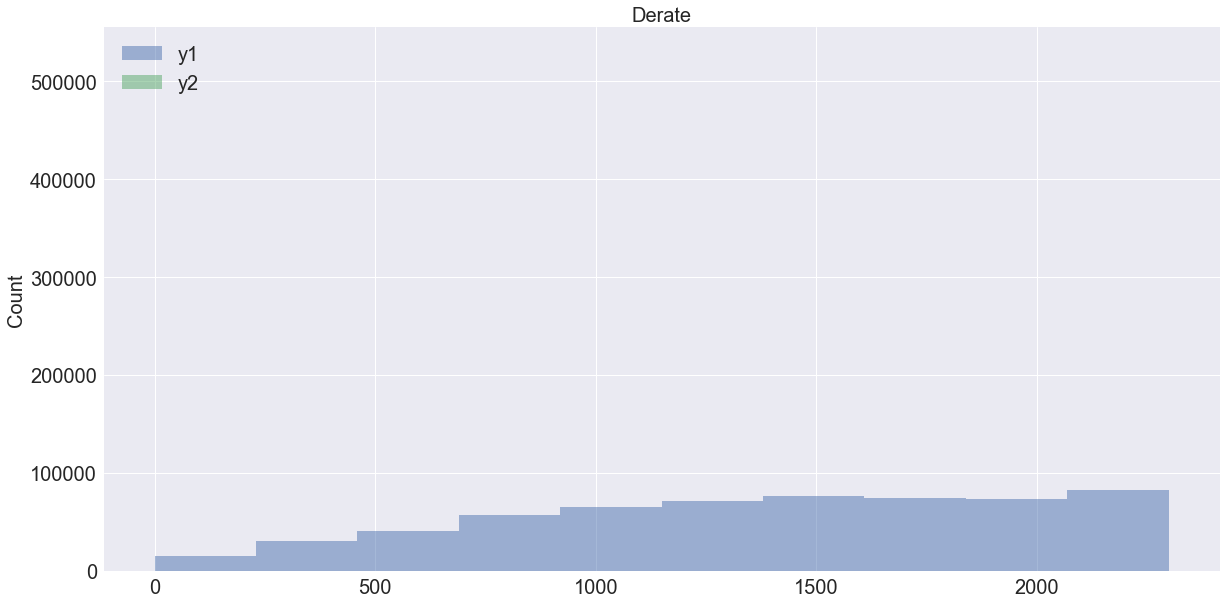

In [227]:
# # Derate Histogram

# y1 = df['wtc_PowerRef_endvalue'][df['Derated'] == 1]
# y2 = df['wtc_PowerRef_endvalue'][df['Derated'] == 0]

# # x3 = pcurve.index.values
# # y3 = pcurve['ExpectedEnergy_ref']

# plt.figure(figsize=(20, 10))
# plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
# plt.rc('font', size=20)          # controls default text sizes
# plt.rc('axes', titlesize=20)     # fontsize of the axes title
# plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
# plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
# plt.rc('legend', fontsize=20)    # legend fontsize
# plt.rc('figure', titlesize=30)  # fontsize of the figure title

# plt.hist(y1, alpha=0.5, label='y1')
# plt.hist(y2, alpha=0.5, label='y2')
# # plt.plot(x3, y3, linestyle = 'dashed', label='Reference')
# #plt.axhline(y=2300, color='k')
# plt.title("Derate")
# # plt.xlabel('Date')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

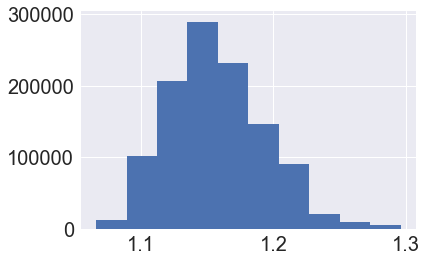

In [161]:
df['Air_density'].hist()

In [11]:
pd.crosstab(df['Available'],df['Fault Type'])

Fault Type,Fault,Warning
Available,,
0,16488,82199
1,0,1025522


In [7]:
# use smaller dataset to test

turbines = ['T003','T062','T093']
# turbines = ['T014']
#turbines = ['T003','T009','T014','T015','T022','T056','T071'] # known main bearing failures

df2 = df.loc[(df['Name'].isin(turbines)) & (df['Available'] == 1) & (df['Derated'] == 0)]

df2.shape
# df3 = df2['2017-1-10':'2017-1-31']

(16944, 43)

In [233]:
cols = ['wtc_ActPower_mean','wtc_PowerRef_endvalue']
df3 = df2[cols].resample('D').median()
df3.shape

(89, 2)

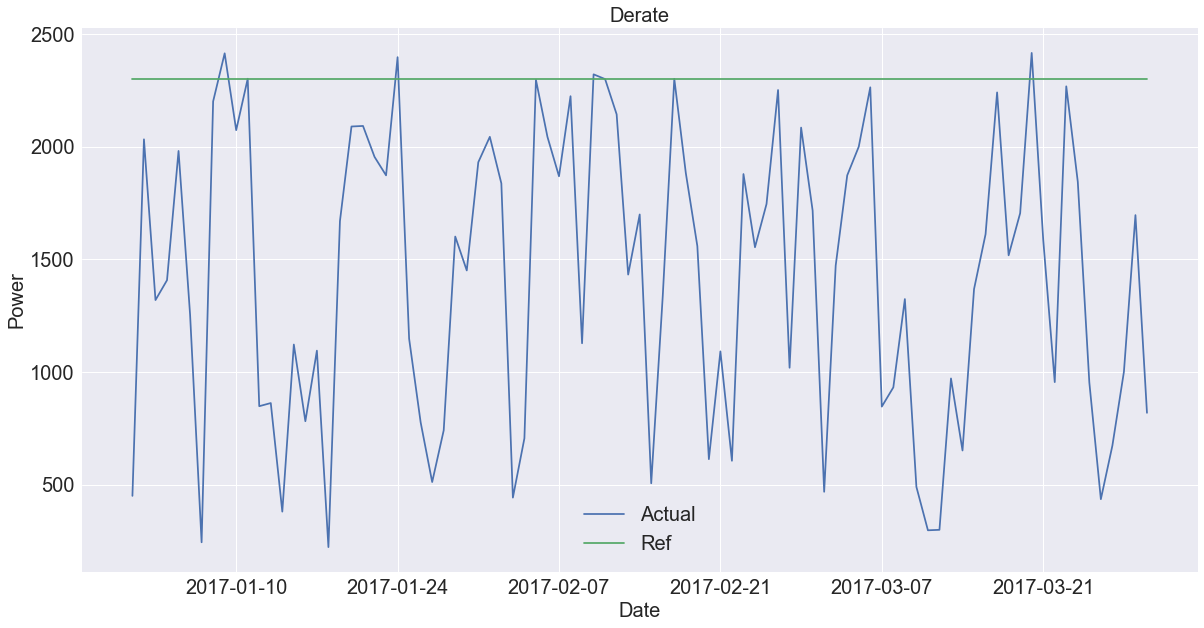

In [234]:
# Derate 

cols = ['wtc_ActPower_mean','wtc_PowerRef_endvalue']
df3 = df2[cols].resample('D').median()

x1 = df3.index.values
y1 = df3['wtc_ActPower_mean']

x2 = x1
y2 = df3['wtc_PowerRef_endvalue']

# x3 = pcurve.index.values
# y3 = pcurve['ExpectedEnergy_ref']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1, label='Actual')
plt.plot(x2, y2, label='Ref')
# plt.plot(x3, y3, linestyle = 'dashed', label='Reference')
#plt.axhline(y=2300, color='k')
plt.title("Derate")
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.show()

In [8]:
pcurvemax = df2.groupby('WindSpeed_adj').max()
pcurve75 = df2.groupby('WindSpeed_adj').quantile(q=0.75)
pcurve50 = df2.groupby('WindSpeed_adj').median()
pcurve25 = df2.groupby('WindSpeed_adj').quantile(q=0.25)
pcurvemin = df2.groupby('WindSpeed_adj').min()

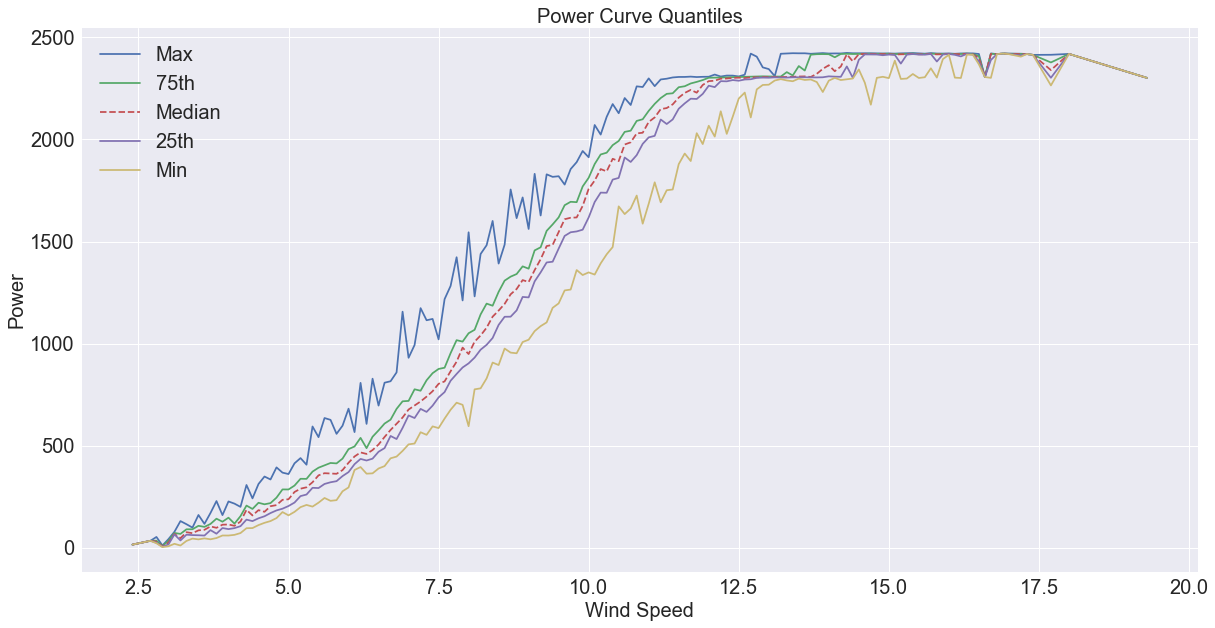

In [236]:
x1 = pcurvemax.index.values
y1 = pcurvemax['wtc_ActPower_mean'] 

x2 = pcurve75.index.values
y2 = pcurve75['wtc_ActPower_mean'] 

x3 = pcurve50.index.values
y3 = pcurve50['wtc_ActPower_mean'] 

x4 = pcurve25.index.values
y4 = pcurve25['wtc_ActPower_mean'] 

x5 = pcurvemin.index.values
y5 = pcurvemin['wtc_ActPower_mean'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1, label='Max')
plt.plot(x2, y2, label='75th')
plt.plot(x3, y3, linestyle = 'dashed', label='Median')
plt.plot(x4, y4, label='25th')
plt.plot(x5, y5, label='Min')

# plt.axhline(y=2300, color='k')
plt.title("Power Curve Quantiles")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

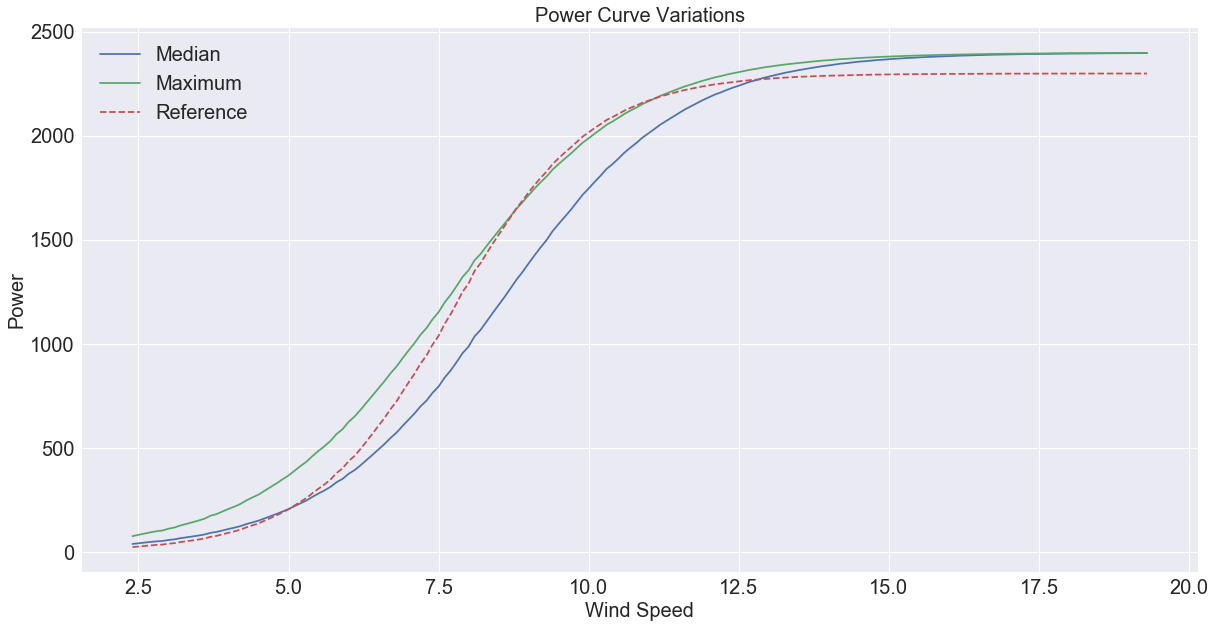

In [91]:
x1 = pcurve.index.values
y1 = pcurve['ExpectedEnergy_median'] #pcurve['wtc_ActPower_mean']

x2 = pcurve.index.values
y2 = pcurve['ExpectedEnergy_max'] #pcurvemax['wtc_ActPower_mean']

x3 = pcurve.index.values
y3 = pcurve['ExpectedEnergy_ref']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1, label='Median')
plt.plot(x2, y2, label='Maximum')
plt.plot(x3, y3, linestyle = 'dashed', label='Reference')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve Variations")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

In [9]:
def PowerCurve(wind, x0,k,cap):
    y = cap / (1 + np.exp(-k*(wind-x0)))
    return y


In [10]:
df2['ExpectedEnergy_ref'] = df2.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], x0=7.70514731, k=0.85471648, cap=2300), axis = 1)
df2['ExpectedEnergy_max'] = df2.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], x0=7.59839901, k=0.65526381,cap=2400), axis = 1)
df2['ExpectedEnergy_median'] = df2.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], x0=8.52821554, k=0.66779164, cap=2400), axis = 1)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [11]:
df2['Residual_ref'] = df2['wtc_ActPower_mean'] - df2['ExpectedEnergy_ref']
df2['Residual_max'] = df2['wtc_ActPower_mean'] - df2['ExpectedEnergy_max']
df2['Residual_median'] = df2['wtc_ActPower_mean'] - df2['ExpectedEnergy_median']

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

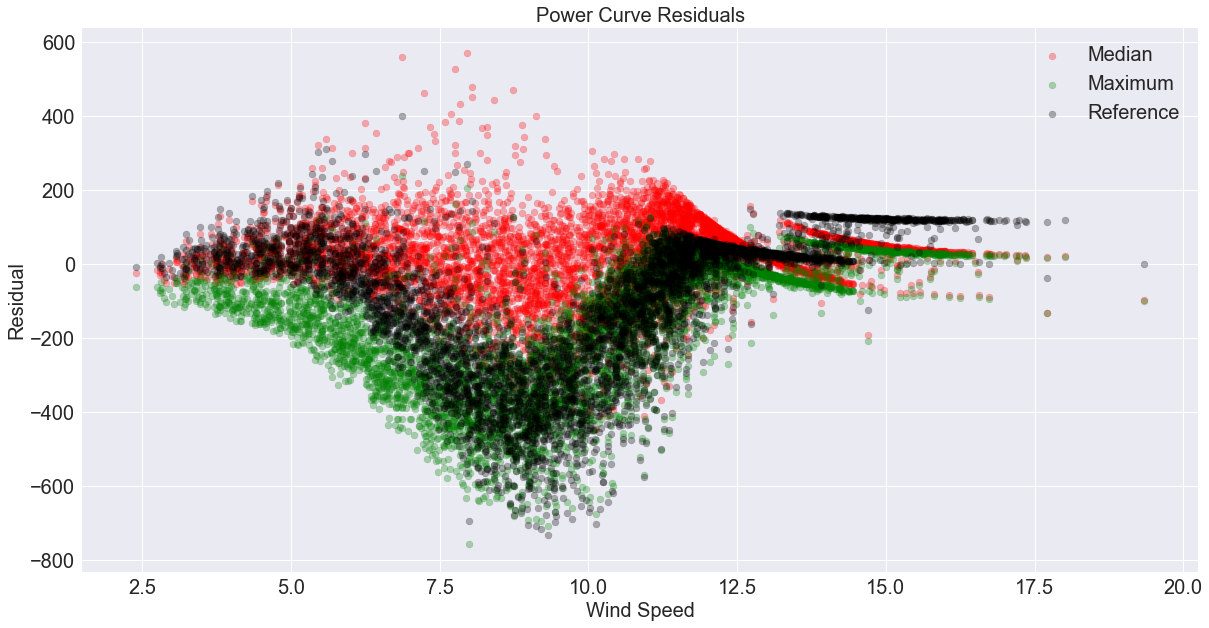

In [102]:
x1 = df2['wtc_AcWindSp_mean']
y1 = df2['Residual_median'] 

x2 = df2['wtc_AcWindSp_mean']
y2 = df2['Residual_max'] 

x3 = df2['wtc_AcWindSp_mean']
y3 = df2['Residual_ref']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x1, y1,alpha=0.3, label='Median', c='r')
plt.scatter(x2, y2,alpha=0.3, label='Maximum', c='g')
plt.scatter(x3, y3,alpha=0.3, label='Reference', c='k')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve Residuals")
plt.xlabel('Wind Speed')
plt.ylabel('Residual')
plt.legend()
plt.show()

## Visualizations

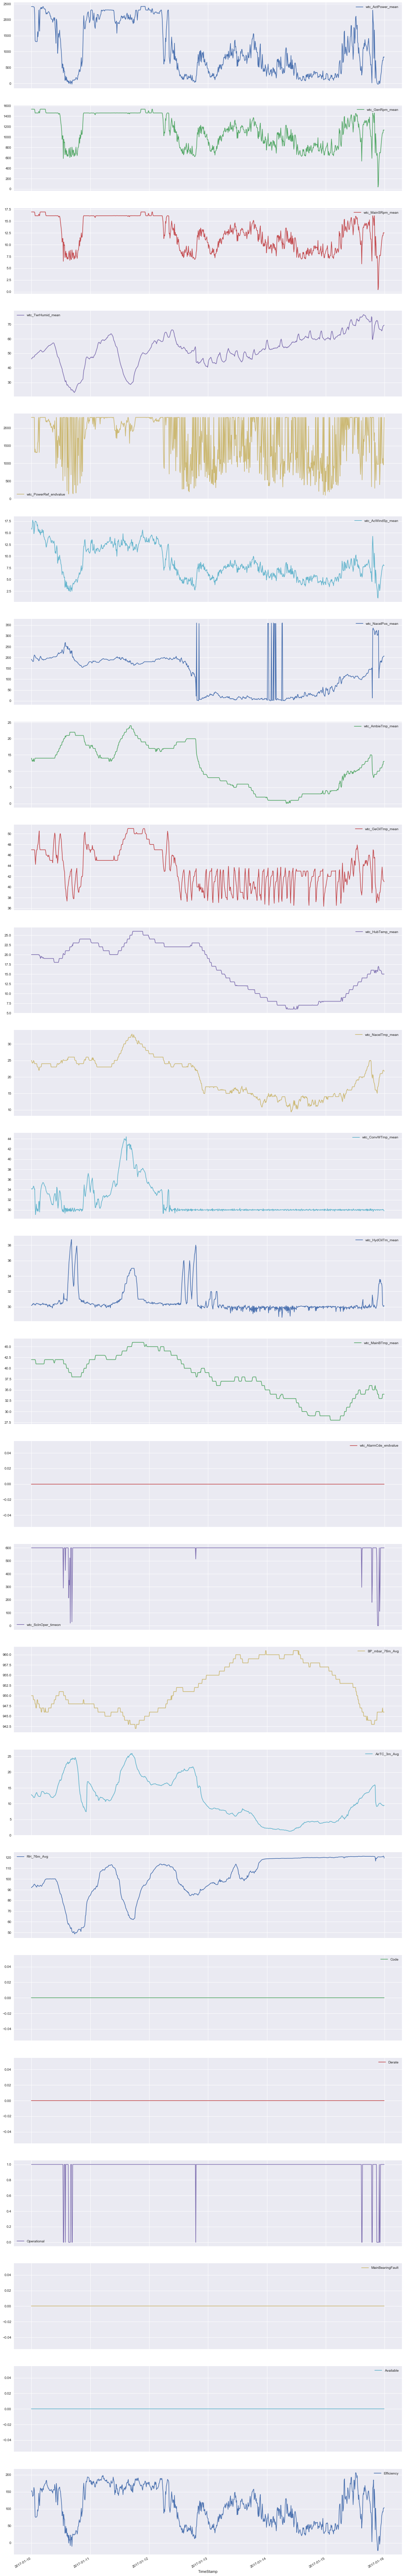

In [17]:
cols = ['wtc_ActPower_mean', 'wtc_GenRpm_mean',
       'wtc_MainSRpm_mean', 'wtc_TwrHumid_mean', 'wtc_PowerRef_endvalue',
       'wtc_AcWindSp_mean', 'wtc_NacelPos_mean', 'wtc_AmbieTmp_mean',
       'wtc_GeOilTmp_mean', 'wtc_HubTemp_mean', 'wtc_NacelTmp_mean',
       'wtc_ConvWTmp_mean', 'wtc_HydOilTm_mean', 'wtc_MainBTmp_mean',
       'wtc_AlarmCde_endvalue', 'wtc_ScInOper_timeon', 'BP_mbar_76m_Avg',
       'AirTC_3m_Avg', 'RH_76m_Avg', 'Code', 'Description', 'Fault Type',
       'Derate', 'Operational', 'MainBearingFault', 'Available', 'Efficiency']
df2[cols].plot(subplots=True, figsize=(20, 150));

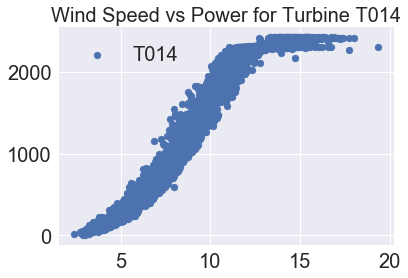

In [240]:
import matplotlib as mpl
# What are the columns
by_turbine = df2.groupby('Name')

x = df2['wtc_AcWindSp_mean']
y = df2['wtc_ActPower_mean']
color = df2['Available']


for name, group in by_turbine:
    plt.scatter(x, 
                y, 
                #c = color,
                label=name)
    plt.title("Wind Speed vs Power for Turbine " + str(name))
    plt.legend()
    plt.show()

## Power Curve Analysis

[ 7.70514731  0.85471648]


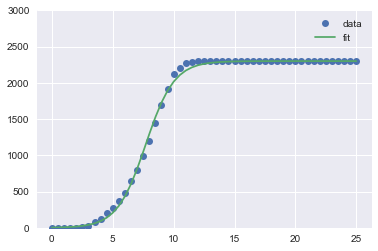

In [22]:
# Reference Curve
import pylab
from scipy.optimize import curve_fit
#from sklearn import preprocessing

ref = pd.read_csv(path + "LGW_RefPowerCurve.csv")

def sigmoid(x, x0, k):
    cap = 2300
    y = cap / (1 + np.exp(-k*(x-x0)))
    return y

xdata = ref['WindSpeed'].values
ydata = ref['Power'].values

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

# xdata = df2['wtc_AcWindSp_mean'].values
# ydata = df2['wtc_ActPower_mean'].values

# popt, pcov = curve_fit(sigmoid, xdata, ydata)
# print(popt)

x = xdata
y = sigmoid(x,*popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

[ 8.52821554  0.66779164]
Cap= 2420.109


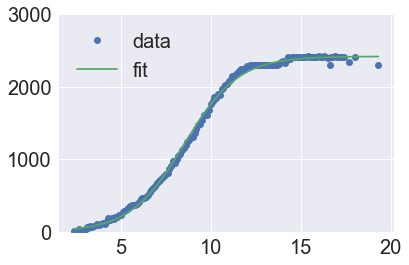

In [77]:
# Historical Median

import pylab
from scipy.optimize import curve_fit
#from sklearn import preprocessing

def sigmoid(x, x0, k):
    #cap = 2300
    y = cap / (1 + np.exp(-k*(x-x0)))
    return y

xdata = pcurve.index.values
ydata = pcurve['wtc_ActPower_mean'].values
cap = np.max(pcurve['wtc_ActPower_mean'].values)

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)
print('Cap=',cap)

x = xdata
y = sigmoid(x,*popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

[ 7.59839901  0.65526381]
Cap= 2423.161


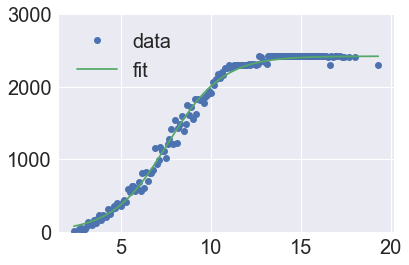

In [81]:
# Historical Maximum

import pylab
from scipy.optimize import curve_fit
#from sklearn import preprocessing

def sigmoid(x, x0, k):
    #cap = 2300
    y = cap / (1 + np.exp(-k*(x-x0)))
    return y

xdata = pcurvemax.index.values
ydata = pcurvemax['wtc_ActPower_mean'].values
cap = np.max(pcurvemax['wtc_ActPower_mean'].values)

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)
print('Cap=',cap)

x = xdata
y = sigmoid(x,*popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

# Classification of Turbine Performance Using SVM
The goal of this model is to predict if a wind turbine is performing in one of three ways: minimum performance, average (or median performance), or maximum performance.

## Feature Engineering
In order to perform this analysis, class labels will have to be created. This is done by creating a simple function and applying it to the data frame.

In [31]:
# Make labels
# insipred by: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns


def make_class(row):
    if row["wtc_ActPower_mean"] <= row["ExpectedEnergy_median"]:
        return "Min"
    elif row["wtc_ActPower_mean"] >= row["ExpectedEnergy_max"]:
        return "Max"
    else:
        return "Average"

df2["Class"] = df2.apply(lambda x: make_class(x), axis=1)
df2.head()


/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Name,wtc_ActPower_mean,wtc_BoostAva_mean,wtc_PowerRef_endvalue,wtc_AcWindSp_mean,wtc_AcWindSp_stddev,wtc_NacelPos_mean,wtc_AmbieTmp_mean,wtc_GeOilTmp_mean,wtc_HubTemp_mean,...,Derated,Available,Air_density,ExpectedEnergy_ref,ExpectedEnergy_max,ExpectedEnergy_median,Residual_ref,Residual_max,Residual_median,Class
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,T003,1824.7080,0.0,2300.0,11.212080,0.460868,334.571400,9.000000,48.98668,15.00000,...,0,1,1.168160,2190.653471,2194.434393,2057.290586,-365.945471,-369.726393,-232.582586,Min
2017-01-01 00:10:00,T003,1603.9590,0.0,2300.0,10.679590,0.534775,338.162100,9.699783,48.39643,14.82747,...,0,1,1.167870,2132.226193,2118.664410,1939.052240,-528.267193,-514.705410,-335.093240,Min
2017-01-01 00:10:00,T062,1037.6800,0.0,2300.0,8.337077,0.768351,7.556928,9.000000,41.83595,19.00000,...,0,1,1.167870,1453.233150,1484.877123,1123.519377,-415.553150,-447.197123,-85.839377,Min
2017-01-01 00:10:00,T093,467.7046,0.0,2300.0,6.412530,0.806799,341.844800,10.000000,39.94840,19.00000,...,0,1,1.167870,572.326515,755.890815,469.888690,-104.621915,-288.186215,-2.184090,Min
2017-01-01 00:20:00,T003,1430.4170,0.0,2300.0,10.230960,0.504425,340.900000,10.000000,47.99835,14.72072,...,0,1,1.168077,2061.934431,2037.058954,1817.142833,-631.517431,-606.641954,-386.725833,Min


## Preprocessing
According to several references the SVM classifer benefits greatly from scaling of the data. It can speed up the trianing process significantly. SciKitLearn has some built in functions to expidite this processs. First, however, the variables must be encoded from the string class variable into a numeric variable that can be interpreted by SciKitLearn.

In [49]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing

#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df2["Class"].unique()))
df2["target"] = le.transform(df2["Class"])

#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df2["target"]

X = df2.drop(["wtc_PowerRef_endvalue", "ExpectedEnergy_ref", "ExpectedEnergy_max", "ExpectedEnergy_median",
             "Residual_ref", "Residual_max", "Residual_median", "Class", "Description", "Fault_Type", "Name", 
              "wtc_ActPower_mean"], axis=1)
X = preprocessing.scale(X) 

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## Create Training and Test Data (80/20 Split)

In [50]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Create a model and optimize parameters with Grid Search
Since there are many possible parameters that can be put into the classifer, I ran through various kernels and penalty terms to find the strongest possible model based on the input parameters.

SciKitLearn Provides an excellent example on using grid search to find optimal parameters using cross validation.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## Results
The best SVM was a linear kernel with a value of C set to 0.1. It results in perfect prediction of the variables. Very high, and potentially suspect results. However, wind turbines are mechanical systems that are driven purley by physics. Thus, it makes sense that given enough data that perfect (or near perfect) predicitons could be made. It should be noted however, that other kernels and values for C resutled in far less accurate predictions (down to 84% percision).

In [51]:
# Thanks to sklearn for a great example: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the parameters by cross-validation
clist = [0.1, 1, 10, 100]
tuned_parameters = [{'kernel': ['rbf'], 'C': clist},
                    {'kernel': ['linear'], 'C': clist},
                    {'kernel': ['poly'], 'C': clist},
                    {'kernel': ['sigmoid'], 'C': clist}
                   ]
                    
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)

Best parameters set found on development set:

{'C': 0.1, 'kernel': 'linear'}

Grid scores on development set:

0.988 (+/-0.004) for {'C': 0.1, 'kernel': 'rbf'}
0.998 (+/-0.001) for {'C': 1, 'kernel': 'rbf'}
0.999 (+/-0.001) for {'C': 10, 'kernel': 'rbf'}
0.999 (+/-0.001) for {'C': 100, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 0.1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
0.873 (+/-0.011) for {'C': 0.1, 'kernel': 'poly'}
0.987 (+/-0.002) for {'C': 1, 'kernel': 'poly'}
0.998 (+/-0.002) for {'C': 10, 'kernel': 'poly'}
0.998 (+/-0.002) for {'C': 100, 'kernel': 'poly'}
0.897 (+/-0.022) for {'C': 0.1, 'kernel': 'sigmoid'}
0.841 (+/-0.009) for {'C': 1, 'kernel': 'sigmoid'}
0.843 (+/-0.023) for {'C': 10, 'kernel': 'sigmoid'}
0.846 (+/-0.021) for {'C': 100, 'kernel': 'sigmoid'}

Detailed classification report:

The model is trained on the full development set.


## Investigation of chosen support vectors

In [55]:
#First I want to create a new model object based on the results of the Grid Search
svm_class = svm.SVC(C=0.1, kernel='linear', gamma='auto')
svm_class.fit(X_train,y_train)

#borrowed from Machine Learning notebook 4
y_hat = svm_class.predict(X_test)
acc = accuracy_score(y_test,y_hat)
conf = confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)



accuracy: 1.0
[[1577    0    0]
 [   0  717    0]
 [   0    0 1095]]


In [61]:
#Results are the same as the grid search (logic check)

#Now I want to investigate the chosen support vectors
sv = svm_class.support_vectors_
sv

array([[-0.36219805, -1.23337597, -0.41914885, ...,  0.        ,
         0.77732194, -0.9856152 ],
       [-0.36219805,  0.50325099, -0.98343347, ...,  0.        ,
        -1.24430624, -0.9856152 ],
       [-0.36219805, -0.25185745,  2.33044358, ...,  0.        ,
        -0.10835256, -0.9856152 ],
       ...,
       [-0.36219805, -2.11142805, -1.44617735, ...,  0.        ,
         0.79334573,  1.30475907],
       [-0.36219805,  0.40546439,  2.73587885, ...,  0.        ,
        -1.35519472,  1.30475907],
       [-0.36219805,  1.03210703,  0.7221599 , ...,  0.        ,
        -1.37413925,  1.30475907]])

## SVM To Do:
1. Investigate chosen support vectors (need to discuss with team)
2. Make sure I do not have any variables that are leaking information to the model.
3. Compare to logistic regression classification model
4. Conduct write up